In [2]:
import numpy as np
import matplotlib.pyplot as plt
import control
import time

class Benchmark():
    def __init__(self,mu,Nsc=1):
        self.mu = mu # gravitational constant
        self.kJ2 = 0 #self.kJ2 = 2.6330e+10
        self.ome = 7.2921e-5
        self.Cd = 0 #self.Cd = 1
        self.mass = 1
        self.rho = 1e-8
        self.Area = 1
        self.Cdj = self.Cd
        self.massj = self.mass
        self.rhoj = self.rho
        self.Areaj = self.Area
        self.Nsc = Nsc # number of spacecrafts
        self.n2 = 3
        self.h = 0.1
        self.Lamdd = 1*np.identity(3)
        K1 = np.identity(3)*5
        K2 = np.identity(3)*2
        self.Lap = self.getlaplacian(K1,-K2)
        self.getparams()
        
    def scdynamics_radial(self,t,X,U,m1,w):
        r = X[0]
        v = X[2]
        om = X[3]
        u1 = U[0]
        u2 = U[1]
        mu = self.mu
        drhodv = v
        dphdt = om
        dvdt = r*om**2-mu/r**2+u1+w
        domdt = -2*v*om/r+u2/r+m1/r
        dXdt = np.array([drhodv,dphdt,dvdt,domdt])
        return dXdt
        
    def scdynamics_cartesian(self,t,X,U):
        mu = self.mu
        dxdt = -mu*X[0:2]/(np.linalg.norm(X))**3+U
        dXdt = np.hstack((X[2:4],dxdt))
        return dXdt
    
    def scdynamics_radial_3d(self,t,X,U,m1,w):
        mu = self.mu
        kJ2 = self.kJ2
        ome = self.ome
        Cd = self.Cd
        mass = self.mass
        rho = self.rho
        Area = self.Area
        uR = U[0]
        uT = U[1]
        uN = U[2]
        r = X[0]
        vx = X[1]
        h = X[2]
        Om = X[3]
        i = X[4]
        th = X[5]
        si = np.sin(i)
        ci = np.cos(i)
        s2i = np.sin(2*i)
        sth = np.sin(th)
        cth = np.cos(th)
        s2th = np.sin(2*th)
        C = Cd*(Area/mass)*rho/2
        Va = np.array([vx,h/r-ome*r*ci,ome*r*cth*si])
        va = np.linalg.norm(Va)
        drdt = vx
        dvxdt = -mu/r**2+h**2/r**3-kJ2/r**4*(1-3*si**2*sth**2)-C*va*vx+uR+w
        dhdt = -kJ2*si**2*s2th/r**3-C*va*(h-ome*r**2*ci)+r*uT+r*m1
        dOmdt = -2*kJ2*ci*sth**2/h/r**3-C*va*ome*r**2*s2th/2/h+(r*sth/h/si)*uN
        didt = -kJ2*s2i*s2th/2/h/r**3-C*va*ome*r**2*si*cth**2/h+(r*cth/h)*uN
        dthdt = h/r**2+2*kJ2*ci**2*sth**2/h/r**3+C*va*ome*r**2*ci*s2th/2/h-(r*sth*ci/h/si)*uN
        dXdt = np.array([drdt,dvxdt,dhdt,dOmdt,didt,dthdt])
        return dXdt
    
    def relativef(self,t,Xj,Xc,Uj,Uc,m1c,wc,m1j,wj):
        mu = self.mu
        kJ2 = self.kJ2
        ome = self.ome
        Cd = self.Cd
        mass = self.mass
        rho = self.rho
        Area = self.Area
        Cdj = self.Cdj
        massj = self.massj
        rhoj = self.rhoj
        Areaj = self.Areaj
        C = Cd*(Area/mass)*rho/2
        Cj = Cdj*(Areaj/massj)*rhoj/2
        xj = Xj[0]
        yj = Xj[1]
        zj = Xj[2]
        xjdot = Xj[3]
        yjdot = Xj[4]
        zjdot = Xj[5]
        r = Xc[0]
        vx = Xc[1]
        h = Xc[2]
        Om = Xc[3]
        i = Xc[4]
        th = Xc[5]
        uR = Uc[0]
        uT = Uc[1]
        uN = Uc[2]
        dXcdt = self.scdynamics_radial_3d(t,Xc,Uc,m1c,wc)
        Omdot = dXcdt[3]
        idot = dXcdt[4]
        thdot = dXcdt[5]
        si = np.sin(i)
        ci = np.cos(i)
        s2i = np.sin(2*i)
        sth = np.sin(th)
        cth = np.cos(th)
        s2th = np.sin(2*th)
        lj = Xj[0:3]
        ljdot = Xj[3:6]
        Va = np.array([vx,h/r-ome*r*ci,ome*r*cth*si])
        va = np.linalg.norm(Va)
        omx = idot*cth+Omdot*sth*si+r/h*uN
        omz = thdot+Omdot*ci
        om_vec = np.array([omx,0,omz])
        Vaj = Va+ljdot+np.cross(om_vec,lj)
        vaj = np.linalg.norm(Vaj)
        rj = np.sqrt((r+xj)**2+yj**2+zj**2)
        rjZ = (r+xj)*si*sth+yj*si*cth+zj*ci
        zt = 2*kJ2*si*sth/r**4
        ztj = 2*kJ2*rjZ/rj**5
        alx = -kJ2*s2i*cth/r**5+3*vx*kJ2*s2i*sth/r**4/h-8*kJ2**2*si**3*ci*sth**2*cth/r**6/h**2
        alz = -2*h*vx/r**3-kJ2*si**2*s2th/r**5
        et = np.sqrt(mu/r**3+kJ2/r**5-5*kJ2*si**2*sth**2/r**5)
        etj = np.sqrt(mu/rj**3+kJ2/rj**5-5*kJ2*rjZ**2/rj**7)
        xjddot = 2*yjdot*omz-xj*(etj**2-omz**2)+yj*alz-zj*omx*omz-(ztj-zt)*si*sth-r*(etj**2-et**2)-Cj*vaj*(xjdot-yj*omz)-(Cj*vaj-C*va)*vx-(uR+wc)
        yjddot = -2*xjdot*omz+2*zjdot*omx-xj*alz-yj*(etj**2-omz**2-omx**2)+zj*alx-(ztj-zt)*si*cth-Cj*vaj*(yjdot+xj*omz-zj*omx)-(Cj*vaj-C*va)*(h/r-ome*r*ci)-(uT+m1c)
        zjddot = -2*yjdot*omx-xj*omx*omz-yj*alx-zj*(etj**2-omx**2)-(ztj-zt)*ci-Cj*vaj*(zjdot+yj*omx)-(Cj*vaj-C*va)*ome*r*cth*si-uN
        eyeq = np.identity(3)
        Zj = np.zeros((3,3))
        Bj = np.vstack((Zj,eyeq))
        Lj = np.array([0,0,0,1,0,0])
        Pj = np.array([0,0,0,0,1,0])
        dXjdt = np.array([xjdot,yjdot,zjdot,xjddot,yjddot,zjddot])+Bj@Uj+Lj*m1j+Pj*wj
        return dXjdt

    def dynamics_all(self,t,Xjcall,Ujcall,m1jcall,wjcall):
        p = self.Nsc
        Xjall = Xjcall[0:6*p]
        Xc = Xjcall[6*p:6*(p+1)]
        Ujall = Ujcall[0:3*p]
        Uc = Ujcall[3*p:3*(p+1)]
        m1c = m1jcall[p]
        wc = wjcall[p]
        dXdcalldt = np.zeros_like(Xjcall)
        for j in range(p):
            Xj = Xjall[6*j:6*(j+1)]
            Uj = Ujall[3*j:3*(j+1)]
            m1j = m1jcall[j]
            wj = wjcall[j]
            dXdcalldt[6*j:6*(j+1)] = self.relativef(t,Xj,Xc,Uj,Uc,m1c,wc,m1j,wj)
        dXdcalldt[6*p:6*(p+1)] = self.scdynamics_radial_3d(t,Xc,Uc,m1c,wc)
        return dXdcalldt
        
    def lagrangeMCGDj(self,t,Xj,Xc,Uc):
        mu = self.mu
        kJ2 = self.kJ2
        ome = self.ome
        Cd = self.Cd
        mass = self.mass
        rho = self.rho
        Area = self.Area
        Cdj = self.Cdj
        massj = self.massj
        rhoj = self.rhoj
        Areaj = self.Areaj
        C = Cd*(Area/mass)*rho/2
        Cj = Cdj*(Areaj/massj)*rhoj/2
        xj = Xj[0]
        yj = Xj[1]
        zj = Xj[2]
        xjdot = Xj[3]
        yjdot = Xj[4]
        zjdot = Xj[5]
        r = Xc[0]
        vx = Xc[1]
        h = Xc[2]
        Om = Xc[3]
        i = Xc[4]
        th = Xc[5]
        uR = Uc[0]
        uT = Uc[1]
        uN = Uc[2]
        dXcdt = self.scdynamics_radial_3d(t,Xc,Uc,0,0)
        Omdot = dXcdt[3]
        idot = dXcdt[4]
        thdot = dXcdt[5]
        si = np.sin(i)
        ci = np.cos(i)
        s2i = np.sin(2*i)
        sth = np.sin(th)
        cth = np.cos(th)
        s2th = np.sin(2*th)
        lj = Xj[0:3]
        ljdot = Xj[3:6]
        Va = np.array([vx,h/r-ome*r*ci,ome*r*cth*si])
        va = np.linalg.norm(Va)
        omx = idot*cth+Omdot*sth*si+r/h*uN
        omz = thdot+Omdot*ci
        om_vec = np.array([omx,0,omz])
        Vaj = Va+ljdot+np.cross(om_vec,lj)
        vaj = np.linalg.norm(Vaj)
        rj = np.sqrt((r+xj)**2+yj**2+zj**2)
        rjZ = (r+xj)*si*sth+yj*si*cth+zj*ci
        zt = 2*kJ2*si*sth/r**4
        ztj = 2*kJ2*rjZ/rj**5
        alx = -kJ2*s2i*cth/r**5+3*vx*kJ2*s2i*sth/r**4/h-8*kJ2**2*si**3*ci*sth**2*cth/r**6/h**2
        alz = -2*h*vx/r**3-kJ2*si**2*s2th/r**5
        et = np.sqrt(mu/r**3+kJ2/r**5-5*kJ2*si**2*sth**2/r**5)
        etj = np.sqrt(mu/rj**3+kJ2/rj**5-5*kJ2*rjZ**2/rj**7)
        Mmat = np.identity(3)
        Cmat = -2*np.array([[0,omz,0],[-omz,0,omx],[0,-omx,0]])
        Gmat = np.array([[etj**2-omz**2,-alz,omx*omz],[alz,etj**2-omz**2-omx**2,-alx],[omx*omz,alx,etj**2-omx**2]])@Xj[0:3]+(ztj-zt)*np.array([si*sth,si*cth,ci])+np.array([r*(etj**2-et**2),0,0])
        Dmat = -np.array([-Cj*vaj*(xjdot-yj*omz)-(Cj*vaj-C*va)*vx-uR,-Cj*vaj*(yjdot+xj*omz-zj*omx)-(Cj*vaj-C*va)*(h/r-ome*r*ci)-uT,-Cj*vaj*(zjdot+yj*omx)-(Cj*vaj-C*va)*ome*r*cth*si-uN])
        return Mmat,Cmat,Gmat,Dmat,dXcdt

    def lagrangeMCGD(self,t,Xjall,Xc,Uc):
        p = self.Nsc
        M = np.zeros((3*p,3*p))
        C = np.zeros((3*p,3*p))
        G = np.zeros(3*p)
        D = np.zeros(3*p)
        for j in range(p):
            Xj = Xjall[6*j:6*(j+1)]
            Mj,Cj,Gj,Dj,dXcdt = self.lagrangeMCGDj(t,Xj,Xc,Uc)
            M[3*j:3*(j+1),3*j:3*(j+1)] = Mj
            C[3*j:3*(j+1),3*j:3*(j+1)] = Cj
            G[3*j:3*(j+1)] = Gj
            D[3*j:3*(j+1)] = Dj
        return M,C,G,D,dXcdt
    
    def gettransmats(self,xe,ye,ze,psie0,psiz0):
        p = self.Nsc
        n2 = self.n2
        lmin,lmax,PHI = self.getmaxes(xe,ye,ze,psie0,psiz0)
        R11 = -xe/lmin*np.sin(PHI-psie0)
        R12 = ye/lmin*np.cos(PHI-psie0)
        R13 = -ze/lmin*np.sin(PHI-psiz0)
        R21 = -xe/lmax*np.cos(PHI-psie0)
        R22 = -ye/lmax*np.sin(PHI-psie0)
        R23 = -ze/lmax*np.cos(PHI-psiz0)
        R31 = -ye*ze/lmin/lmax*np.cos(psie0-psiz0)
        R32 = xe*ze/lmin/lmax*np.sin(psie0-psiz0)
        R33 = xe*ye/lmin/lmax
        R1d = np.array([[R11,R12,R13],[R21,R22,R23],[R31,R32,R33]])
        R2d = np.array([[1,0,0],[0,lmin/lmax,0],[0,0,1]])
        Rfd = R2d@R1d
        Tall = np.zeros((n2*p,n2*p))
        idx = 1
        nidx = 4
        phi0 = 0
        dphi = 0
        for j in range(p):
            if j > nidx/2*idx*(idx+1):
                phi0 = phi0+dphi
                idx = idx+1
            sat_num = nidx*idx
            phi = 2*np.pi/sat_num
            Tz = np.array([[np.cos((j-1)*phi+phi0),-np.sin((j-1)*phi+phi0)],[np.sin((j-1)*phi+phi0),np.cos((j-1)*phi+phi0)]])
            Tz = idx*np.identity(2)@Tz
            Tall[n2*j:n2*(j+1),n2*j:n2*(j+1)] = np.vstack((np.hstack((Tz,np.zeros((2,1)))),np.hstack((np.zeros(2),1))))
        idx_targets = idx
        return Rfd,Tall,idx_targets
    
    def getmaxes(self,xe,ye,ze,psie0,psiz0):
        numP = (xe**2-ye**2)*np.sin(2*psie0)+ze**2*np.sin(2*psiz0)
        denP = (xe**2-ye**2)*np.cos(2*psie0)+ze**2*np.cos(2*psiz0)
        PHI = 1/2*np.arctan2(numP,denP)
        xdfun = lambda psi: np.array([xe*np.sin(psi+psie0),ye*np.cos(psi+psie0),ze*np.sin(psi+psiz0)])
        lfun = lambda psi: np.linalg.norm(xdfun(psi))
        lmin = lfun(-PHI)
        lmax = lfun(3/2*np.pi-PHI)
        return lmin,lmax,PHI
    
    def getparams(self):
        p = self.Nsc
        n2 = self.n2
        n_u = n2*p
        xe = 2
        ye = 2
        ze = 0.
        pe0 = np.deg2rad(0.573)
        pz0 = np.deg2rad(11.46)
        nphase = 0.0011
        qd = lambda t: np.array([xe*np.sin(nphase*t+pe0),ye*np.cos(nphase*t+pe0),ze*np.sin(nphase*t+pz0)])
        qd_dot = lambda t: nphase*np.array([xe*np.cos(nphase*t+pe0),-ye*np.sin(nphase*t+pe0),ze*np.cos(nphase*t+pz0)])
        qd_ddot = lambda t: -nphase**2*np.array([xe*np.sin(nphase*t+pe0),ye*np.cos(nphase*t+pe0),ze*np.sin(nphase*t+pz0)])
        Rfd,Tall,idx_targets = self.gettransmats(xe,ye,ze,pe0,pz0)
        Qd = lambda t: np.array([qd(t),qd_dot(t),qd_ddot(t)])
        d0 = 0.2
        v0 = 0.4
        q0_all = np.zeros(n_u)
        q0_dot_all = np.zeros(n_u)
        for j in range(p):
            xj0 = -d0+2*d0*np.random.rand(1)[0]
            yj0 = -d0+2*d0*np.random.rand(1)[0]
            zj0 = -d0+2*d0*np.random.rand(1)[0]
            q0_all[n2*j:n2*(j+1)] = np.array([xj0,yj0,zj0])
        self.Qdfun = Qd
        self.q0_all = q0_all
        self.q0_dot_all = q0_dot_all
        self.Rfd = Rfd 
        self.R_d = np.kron(np.identity(p),Rfd)
        self.Tall = Tall
        self.idx_targets = idx_targets       
        Rq2X = np.zeros((2*p,p))
        Rv2X = np.zeros((2*p,p))
        for j in range(p):
            Rq2X[2*j,j] = 1
            Rv2X[2*(j+1)-1,j] = 1
        Rq2X = np.kron(Rq2X,np.identity(n2))
        Rv2X = np.kron(Rv2X,np.identity(n2))
        Rqq2X = np.hstack((Rq2X,Rv2X))
        self.Rqq2X = Rqq2X
        self.Xjall0 = Rqq2X@np.hstack((q0_all,q0_dot_all))            
        self.Bj2d = np.array([[0,0],[0,0],[1,0],[0,1]])
        self.Pj2d = np.array([[0],[0],[0],[1]])
        self.Lj2d = np.array([[0],[0],[1],[0]])
        self.Cj2d = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1]])
        CP = self.Cj2d@self.Pj2d
        self.Nj2d = self.Pj2d@np.linalg.inv((CP).T@CP)@CP.T
        pass
    
    def getXd_at_t(self,t):
        Qd_t = self.Qdfun(t)
        Rfd = self.Rfd
        Tall = self.Tall 
        p = self.Nsc
        n2 = self.n2
        qd_val = Qd_t[0,:]
        qd_dot_val = Qd_t[1,:]
        qd_ddot_val = Qd_t[2,:]
        R_d = self.R_d
        qd_all = np.tile(qd_val,p)
        qd_dot_all = np.tile(qd_dot_val,p)
        qd_ddot_all = np.tile(qd_ddot_val,p)
        qd_all_trans = R_d.T@Tall@R_d@qd_all
        qd_dot_all_trans = R_d.T@Tall@R_d@qd_dot_all
        qd_ddot_all_trans = R_d@Tall@R_d@qd_ddot_all
        #qd_all_trans = np.linalg.solve(R_d,Tall@R_d@qd_all)
        #qd_dot_all_trans = np.linalg.solve(R_d,Tall@R_d@qd_dot_all)
        #qd_ddot_all_trans = np.linalg.solve(R_d,Tall@R_d@qd_ddot_all)
        Xd = self.Rqq2X@np.hstack((qd_all_trans,qd_dot_all_trans))
        return qd_all_trans,qd_dot_all_trans,qd_ddot_all_trans,Xd
    
    def rad2car(self,vrad,th):
        Rot = np.array([[np.cos(th),-np.sin(th)],[np.sin(th),np.cos(th)]])
        vcar = Rot@vrad
        return vcar
    
    def measurement_Xc(self,t,Xc):
        r = Xc[0]
        h = Xc[2]
        th = Xc[5]
        Yc = np.array([r,h,th])
        return Yc
    
    def measurement_Xj(self,t,Xj):
        xj = Xj[0]
        yj = Xj[1]
        dyjdt = Xj[4]
        Yj = np.array([xj,yj,dyjdt])
        return Yj
        
    def residual_filter_Xc(self,t,xi_c,Yc,Uc):
        h = Yc[1]
        r = Yc[0]
        u2 = Uc[1]
        k = 10
        dxi_c_dt = r*u2+k*(h-xi_c)
        return dxi_c_dt
        
    def residual_filter_Xj(self,t,Zj2d,Yj,Uj,Xc,Uc,m1c,wc):       
        B = self.Bj2d
        C = self.Cj2d
        N = self.Nj2d
        Xhatj2d = Zj2d+N@Yj
        phij = self.residual_phij(t,Xhatj2d,Xc,Uc,m1c,wc)
        Aphij = self.residual_Aphij(t,Xhatj2d,Xc,Uc,m1c,wc)
        I = np.identity(4)
        M = I-N@C
        G = M@B
        Aekf = M@Aphij
        Q = np.identity(4)*10
        R = np.identity(3)
        KT,_,_ = control.lqr(Aekf.T,C.T,Q,R)
        K = -KT.T
        F = K@C
        H = K@C@N-K
        dZj2d_dt = F@Zj2d+G@Uj[0:2]+M@phij+H@Yj
        return dZj2d_dt
    
    def residual_phij(self,t,Xj2d,Xc,Uc,m1c,wc):
        mu = self.mu
        xj = Xj2d[0]
        yj = Xj2d[1]
        xjdot = Xj2d[2]
        yjdot = Xj2d[3]
        r = Xc[0]
        vx = Xc[1]
        h = Xc[2]
        uR = Uc[0]
        uT = Uc[1]
        omz = h/r**2
        rj = np.sqrt((r+xj)**2+yj**2)
        alz = -2*h*vx/r**3
        et = np.sqrt(mu/r**3)
        etj = np.sqrt(mu/rj**3)
        xjddot = 2*yjdot*omz-xj*(etj**2-omz**2)+yj*alz-r*(etj**2-et**2)-(uR+wc)
        yjddot = -2*xjdot*omz-xj*alz-yj*(etj**2-omz**2)-(uT+m1c)
        dXj2d_dt = np.array([xjdot,yjdot,xjddot,yjddot])
        return dXj2d_dt
    
    def residual_Aphij(self,t,Xj2d,Xc,Uc,m1c,wc):
        dx = 0.001
        Aphi = np.zeros((4,4))
        for i in range(4):
            ei = np.zeros(4)
            ei[i] = 1
            f1 = self.residual_phij(t,Xj2d+ei*dx,Xc,Uc,m1c,wc)
            f0 = self.residual_phij(t,Xj2d-ei*dx,Xc,Uc,m1c,wc)
            dfdx = (f1-f0)/2/dx
            Aphi[:,i] = dfdx
        return Aphi
    
    def residual_filter_w_Xc_EKF(self,t,Zc,Yc,Uc):
        mu = self.mu
        r_meas = Yc[0]
        B = np.array([[0,0],[1,0],[0,r_meas],[0,0]])
        Pw = np.array([[0],[0],[1],[0]])
        Lw = np.array([[0],[1],[0],[0]])
        C = np.array([[1,0,0,0],[0,0,1,0],[0,0,0,1]])
        CP = C@Pw
        N = Pw@np.linalg.inv((CP).T@CP)@CP.T
        self.Nekf = N
        Xhat_c = Zc+N@Yc
        phi = self.residual_phi_Xc(Xhat_c)
        Aphi = self.residual_Aphi_Xc(Xhat_c)
        I = np.identity(4)
        M = I-N@C
        G = M@B
        Aekf = M@Aphi
        Q = np.identity(4)*0.01
        R = np.identity(3)
        KT,_,_ = control.lqr(Aekf.T,C.T,Q,R)
        K = -KT.T
        F = K@C
        H = K@C@N-K
        dZc_dt = F@Zc+G@Uc[0:2]+M@phi+H@Yc
        return dZc_dt
    
    def residual_phi_Xc(self,Xc2d):
        mu = self.mu
        r = Xc2d[0]
        vx = Xc2d[1]
        h = Xc2d[2]
        phi = np.array([vx,-mu/r**2+h**2/r**3,0,h/r**2])
        return phi
        
    def residual_Aphi_Xc(self,Xc2d):
        dx = 0.001
        Aphi = np.zeros((4,4))
        for i in range(4):
            ei = np.zeros(4)
            ei[i] = 1
            f1 = self.residual_phi_Xc(Xc2d+ei*dx)
            f0 = self.residual_phi_Xc(Xc2d-ei*dx)
            dfdx = (f1-f0)/2/dx
            Aphi[:,i] = dfdx
        return Aphi
    
    def relativeA(self,Xj,Xc,Uc):
        dx = 0.001
        A = np.zeros((self.n_states,self.n_states))
        for i in range(self.n_states):
            ei = np.zeros(self.n_states)
            ei[i] = 1
            f1 = self.relativef(Xj+ei*dx,Xc,Uc)
            f0 = self.relativef(Xj-ei*dx,Xc,Uc)
            dfdx = (f1-f0)/2/dx
            A[:,i] = dfdx
        return A
    
    
    def rk4(self,t,X,U,dynamics):
        h = self.h
        k1 = dynamics(t,X,U)
        k2 = dynamics(t+h/2.,X+k1*h/2.,U)
        k3 = dynamics(t+h/2.,X+k2*h/2.,U)
        k4 = dynamics(t+h,X+k3*h,U)
        return t+h,X+h*(k1+2.*k2+2.*k3+k4)/6.
    
    def getsd(self,Xjall,Qd_t):
        p = self.Nsc
        Rfd = self.Rfd
        Tall = self.Tall
        Lamdd = self.Lamdd
        qq = self.Rqq2X.T@Xjall
        q_all = qq[0:3*p]
        q_dot_all = qq[3*p:6*p]
        qd = Qd_t[0,:]
        qd_dot = Qd_t[1,:]
        qd_ddot = Qd_t[2,:]
        R_d = self.R_d
        Lam_all = np.kron(np.identity(p),Lamdd)
        qd_all = np.tile(qd,p)
        qd_dot_all = np.tile(qd_dot,p)
        qd_ddot_all = np.tile(qd_ddot,p)
        q_d = R_d@q_all
        q_dot_d = R_d@q_dot_all
        qd_d = R_d@qd_all
        qd_dot_d = R_d@qd_dot_all
        qd_ddot_d = R_d@qd_ddot_all
        qr_dot_d = Tall@qd_dot_d-Lam_all@(q_d-Tall@qd_d)
        qr_ddot_d = Tall@qd_ddot_d-Lam_all@(q_dot_d-Tall@qd_dot_d)
        s_d = q_dot_d-qr_dot_d
        return s_d,qr_dot_d,qr_ddot_d
    
    def expcontrol(self,t,Xjall,Xc,Uc,Qd_t):
        p = self.Nsc
        Rfd = self.Rfd
        Lap = self.Lap
        R_d = self.R_d
        M,C,G,D,dXcdt = self.lagrangeMCGD(t,Xjall,Xc,Uc)
        M_d = R_d@M@R_d.T
        C_d = R_d@C@R_d.T
        G_d = R_d@G
        D_d = R_d@D
        s_d,qr_dot_d,qr_ddot_d = self.getsd(Xjall,Qd_t)
        Rfdtau = M_d@qr_ddot_d+C_d@qr_dot_d+G_d+D_d-Lap@s_d
        U = R_d.T@Rfdtau
        return U
    
    def getlaplacian(self,M1,M2):
        p = self.Nsc
        L = np.zeros((3*p,3*p))
        for j in range(p):
            if j == 0:
                L[0:3,0:3] = M1
                L[0:3,3:6] = M2
                L[0:3,3*(p-1):3*p] = M2
            elif j == p-1:
                L[3*(p-1):3*p,3*(p-1):3*p] = M1
                L[3*(p-1):3*p,0:3] = M2
                L[3*(p-1):3*p,3*(p-2):3*(p-1)] = M2
            else:
                L[3*j:3*(j+1),3*j:3*(j+1)] = M1
                L[3*j:3*(j+1),3*(j+1):3*(j+2)] = M2
                L[3*j:3*(j+1),3*(j-1):3*j] = M2
        return L

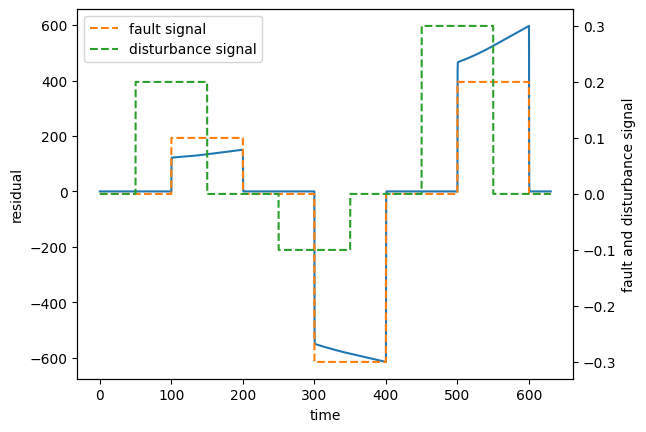

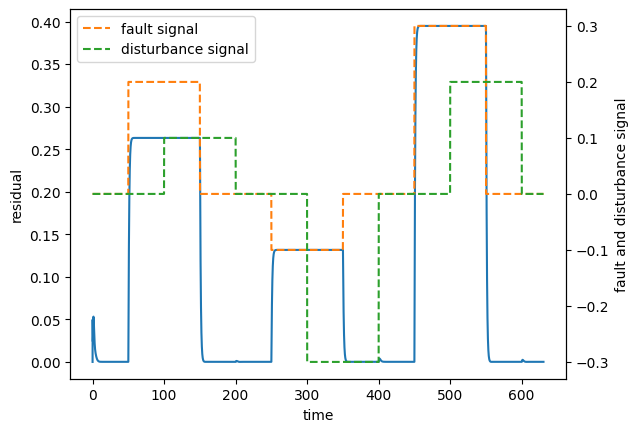

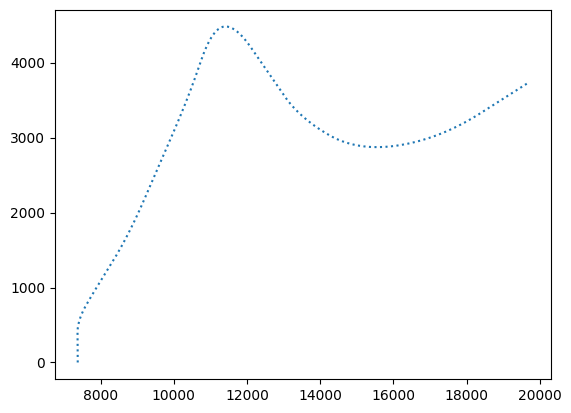

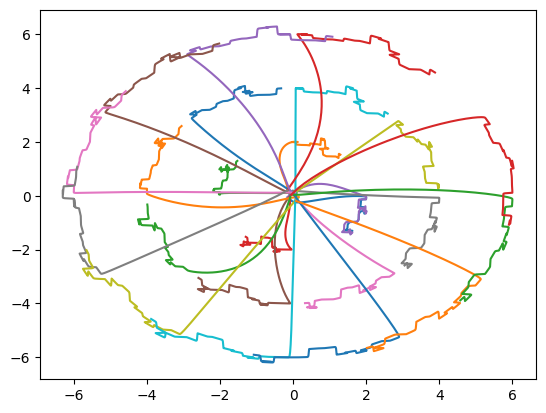

In [3]:
if __name__ == "__main__":
    Nsc = 24
    mu_mars = 42828.375816
    mu_earth = 3.9860e+05
    bm = Benchmark(mu_earth,Nsc)
    t0 = 0
    # initial condition
    r0 = 6378+1000
    vx0 = 0
    vth0 = np.sqrt(bm.mu/r0)
    om0 = vth0/r0
    h0 = om0*r0**2 
    Om0 = np.pi/3
    i0 = np.pi/3
    th0 = 0
    Xc0 = np.array([r0,vx0,h0,Om0,i0,th0])
    Xjcall0 = np.hstack((bm.Xjall0,Xc0))
    xi_c0 = h0
    Yj0 = bm.measurement_Xj(t0,bm.Xjall0[0:6])
    Xhatj2d0 = np.array([bm.Xjall0[0],bm.Xjall0[1],bm.Xjall0[3],bm.Xjall0[4]])
    Zc2d0 = np.array([r0,vx0,h0,th0])
    Zj2d0 = Xhatj2d0-bm.Nj2d@Yj0
    # target trajectory for relative dynamics
    T = 2*np.pi/om0/10
    dt = bm.h
    Nint = int(T/dt)
    Qd_t_his = np.zeros((3,3,Nint+1))
    ti = 0
    for i in range(Nint+1):
        Qd_t_his[:,:,i] = bm.Qdfun(ti)
        ti = ti+dt    
    # integration
    this = np.zeros(Nint+1)
    Xjcallhis = np.zeros((Nint+1,6*(Nsc+1)))
    res_c_his = np.zeros(Nint)
    res_w_his = np.zeros(Nint)
    res_wj_his = np.zeros(Nint)
    m1c_his = np.zeros(Nint)
    wc_his = np.zeros(Nint)
    m1j_his = np.zeros(Nint)
    wj_his = np.zeros(Nint)
    this[0] = t0
    Xjcallhis[0,:] = Xjcall0
    t = t0
    Xjcall = Xjcall0
    xi_c = xi_c0
    Zc2d = Zc2d0
    Zj2d = Zj2d0
    # nominal trajectory
    for k in range(Nint):
        Uc = np.zeros(3)
        Xjall = Xjcall[0:6*Nsc]
        Xc = Xjcall[6*Nsc:6*(Nsc+1)]
        Qd_t = Qd_t_his[:,:,k]
        Ujall = bm.expcontrol(t,Xjall,Xc,Uc,Qd_t)
        Ujcall = np.hstack((Ujall,Uc))
        m1jcall = np.zeros(Nsc+1)
        wjcall = np.zeros(Nsc+1)
        # fault signal
        if 1000 <= k <= 2000:
            wjcall[0] = 0.1
            m1jcall[Nsc] = 0.1
        if 3000 <= k <= 4000:
            wjcall[0] = -0.3
            m1jcall[Nsc] = -0.3
        if 5000 <= k <= 6000:
            wjcall[0] = 0.2
            m1jcall[Nsc] = 0.2
        # disturbance signal
        if 500 <= k <= 1500:
            m1jcall[0] = 0.2
            wjcall[Nsc] = 0.2
        if 2500 <= k <= 3500:
            m1jcall[0] = -0.1
            wjcall[Nsc] = -0.1
        if 4500 <= k <= 5500:
            m1jcall[0] = 0.3
            wjcall[Nsc] = 0.3
        Yc = bm.measurement_Xc(t,Xc)
        Yj = bm.measurement_Xj(t0,Xjall[0:6])
        _ = bm.residual_filter_w_Xc_EKF(t,Zc2d,Yc,Uc)
        Xhatc2d = Zc2d+bm.Nekf@Yc
        Xhatj2d = Zj2d+bm.Nj2d@Yj
        res_c_his[k] = Yc[1]-xi_c
        #res_w_his[k] = np.linalg.norm(Xhatc2d-np.array([Xc[0],Xc[1],Xc[2],Xc[5]]))
        res_wj_his[k] = np.linalg.norm(Xhatj2d-np.array([Xjall[0],Xjall[1],Xjall[3],Xjall[4]]))
        m1j_his[k] = m1jcall[0]
        wj_his[k] = wjcall[0]
        m1c_his[k] = m1jcall[Nsc]
        wc_his[k] = wjcall[Nsc]
        dynamics_jc = lambda t,X,U: bm.dynamics_all(t,X,U,m1jcall,wjcall)
        dynamics_rc = lambda t,X,U: bm.residual_filter_Xc(t,X,Yc,U)
        #dynamics_rw = lambda t,X,U: bm.residual_filter_w_Xc_EKF(t,X,Yc,U)
        dynamics_rj = lambda t,X,U: bm.residual_filter_Xj(t,X,Yj,U,Xc,Uc,m1jcall[Nsc],wjcall[Nsc])
        t,Xjcall = bm.rk4(t,Xjcall,Ujcall,dynamics_jc)
        _,xi_c = bm.rk4(t,xi_c,Uc,dynamics_rc)
        #_,Zc2d = bm.rk4(t,Zc2d,Uc,dynamics_rw)
        _,Zj2d = bm.rk4(t,Zj2d,Ujall[0:3],dynamics_rj)
        this[k+1] = t
        Xjcallhis[k+1,:] = Xjcall
    # figures
    Xchis = Xjcallhis[:,6*Nsc:6*(Nsc+1)]
    Xjallhis = Xjcallhis[:,0:6*Nsc]
    x3dhis = Xchis[:,0]*np.cos(Xchis[:,5])
    y3dhis = Xchis[:,0]*np.sin(Xchis[:,5])
    # residual filter
    fig,ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(this[0:Nint],res_c_his,"C0")
    ax2.plot(this[0:Nint],m1c_his,"C1",linestyle="--")
    ax2.plot(this[0:Nint],wc_his,"C2",linestyle="--")
    ax2.legend(["fault signal","disturbance signal"])
    ax1.set_xlabel("time")
    ax1.set_ylabel("residual")
    ax2.set_ylabel("fault and disturbance signal")
    # residual filter j
    fig,ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(this[0:Nint],res_wj_his,"C0")
    ax2.plot(this[0:Nint],m1j_his,"C1",linestyle="--")
    ax2.plot(this[0:Nint],wj_his,"C2",linestyle="--")
    ax2.legend(["fault signal","disturbance signal"])
    ax1.set_xlabel("time")
    ax1.set_ylabel("residual")
    ax2.set_ylabel("fault and disturbance signal")
    # Positions
    plt.figure()
    plt.plot(x3dhis,y3dhis,linestyle=':')
    plt.figure()
    for p in range(Nsc):
        Xjhis = Xjallhis[:,6*p:6*(p+1)]
        plt.plot(Xjhis[:,0],Xjhis[:,1])